In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [2]:
# Metadata

tempdata = 'oe1.csv' # Data used
timestamp1 = "11:04:06" # Timestamp for daily temperature
timestamp2 = "11:00:00" # Timestamp for daily water level

timerange1 = '2021-8-11 20:00:00'
timerange2 = '2021-9-30 12:00:00'

# Data Manipulation

In [3]:
'''Temperature recorded with iButton'''

temp = pd.read_csv(tempdata, header=20)
temp.time= pd.to_datetime(temp.time)
temp['time'] = temp['time'] + pd.Timedelta(hours=8)
temp = temp[20:-24].reset_index(drop=True)

# date = temp["time"].map(pd.Timestamp.date).unique()
# max = temp.groupby(pd.Grouper(key='time',freq='D'))['temp'].max()
# avg = temp.groupby(pd.Grouper(key='time',freq='D'))['temp'].mean()
# min = temp.groupby(pd.Grouper(key='time',freq='D'))['temp'].min()

# summary = pd.DataFrame(zip(date,max,avg,min), columns=['date', 'max','avg','min'])


'''Tidal height provided by HKO'''

tide = pd.read_csv('SPWPH2021.csv')
tide['year']='2021'
tide.rename(columns = {'MM':'month','DD':'day'}, inplace=True)
tide.insert(0,'time',pd.to_datetime(tide[['year','month','day']]))
tide = tide.drop(columns=['month','day','year'])
tide = pd.melt(tide, id_vars=['time'], var_name='Hour', value_name='level')
tide['time'] = (pd.to_datetime(tide['time'], dayfirst=True) + pd.to_timedelta(tide['Hour'].astype(int), unit='H'))
tide = tide.drop(columns=['Hour']).sort_values(by="time")

In [4]:
# Combine 2 Time Series 

mask = (tide['time'] > timerange1) & (tide['time'] <= timerange2)
slicedtide = tide.loc[mask]
combinedf = pd.concat([temp,slicedtide], ignore_index = True)
combinedf.sort_values(by='time', inplace = True)
combinedf.set_index('time', inplace=True)
combinedf.index = pd.to_datetime(combinedf.index)

combinedf = combinedf.interpolate() #Interpolation

'''Mean Values'''
dailytidemean = slicedtide.resample('D', on='time').mean()
dailytempmean = temp.resample('D', on='time').mean()

combinedmean = pd.concat([dailytempmean,dailytidemean], join='inner', axis=1)

In [5]:
combinedf

,temp,level
time,,
2021-08-11 21:00:00,NaN,1.190
2021-08-11 21:04:06,27.80,1.240
2021-08-11 21:19:06,27.80,1.290
2021-08-11 21:34:06,27.70,1.340
2021-08-11 21:49:06,27.10,1.390
...,...,...
2021-09-30 11:19:06,45.10,0.942
2021-09-30 11:34:06,45.90,0.938
2021-09-30 11:49:06,45.10,0.934


In [6]:
# # Reset Index

temp.set_index('time', inplace=True)
temp.index = pd.to_datetime(temp.index)

tide.set_index('time', inplace=True)
tide.index = pd.to_datetime(tide.index)

slicedtide.set_index('time', inplace=True)
slicedtide.index = pd.to_datetime(slicedtide.index)

# Individual Plot 

## iButton Temperature


[Text(0.5, 1.0, 'Temperature Recorded')]

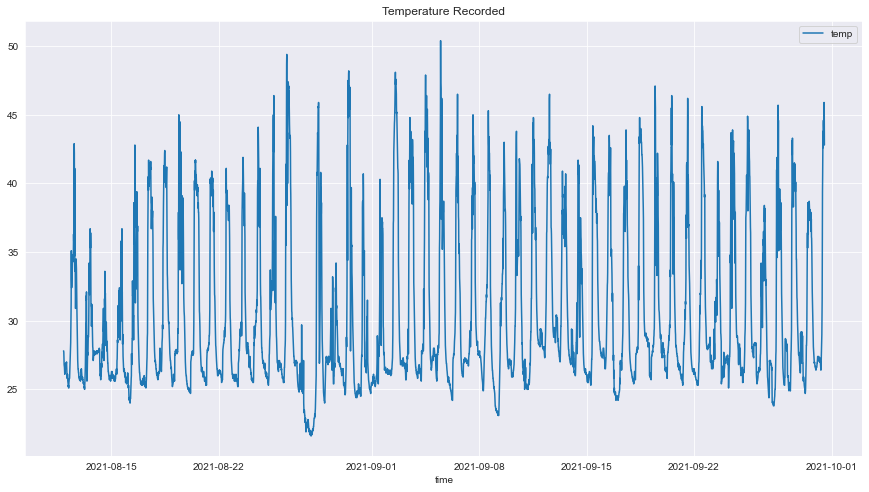

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
sns.lineplot(data=temp).set(title='Temperature Recorded')

[Text(0.5, 1.0, 'Temperature Recorded at 11:04:06')]

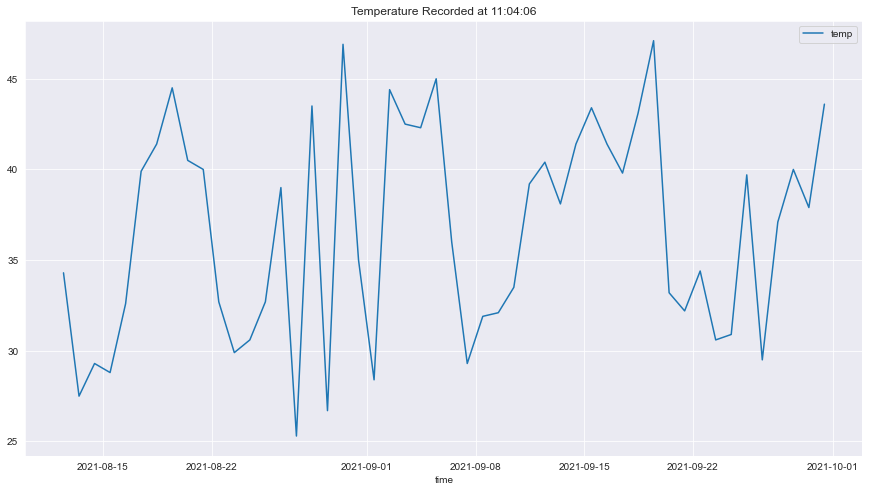

In [8]:
dailytemp = temp.loc[temp.index.strftime("%H:%M:%S") == timestamp1]

sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
sns.lineplot(data=dailytemp).set(title='Temperature Recorded at '+timestamp1)

## HKO Tidal Water Level 

[Text(0.5, 1.0, 'Tidal Water Level')]

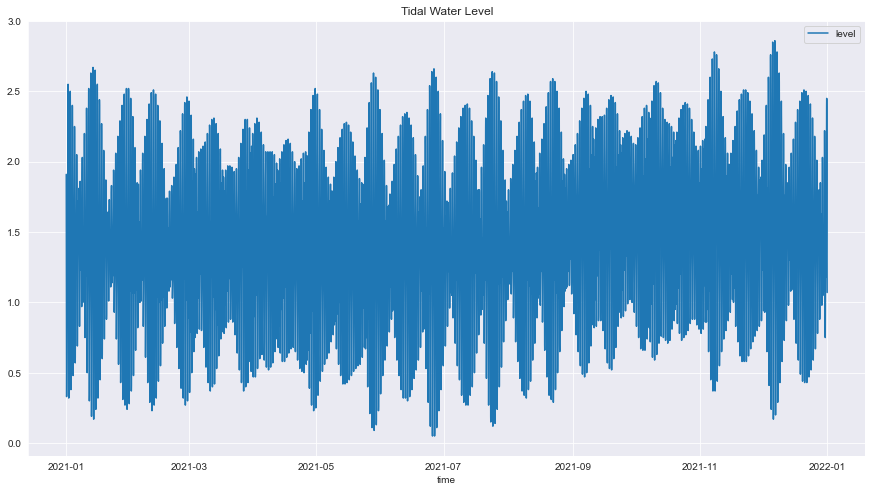

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
sns.lineplot(data=tide).set(title='Tidal Water Level')

[Text(0.5, 1.0, 'Tidal Water Level at 11:00:00')]

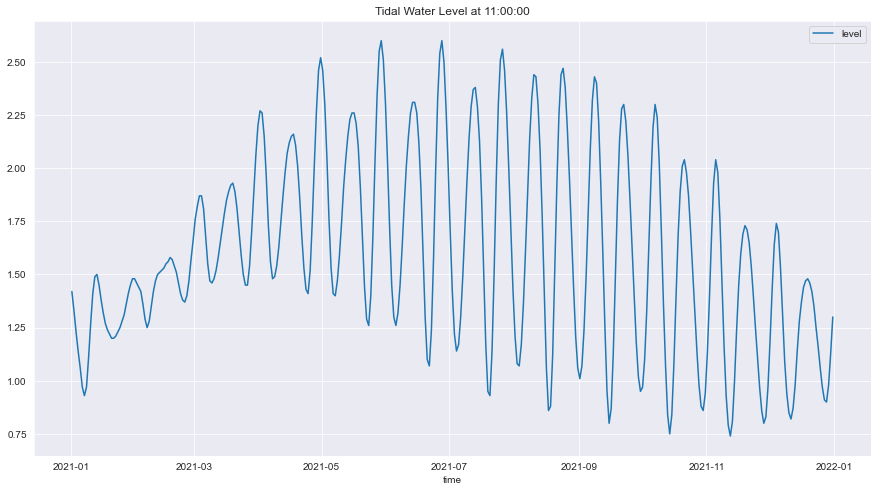

In [32]:
dailytide = tide.loc[tide.index.strftime("%H:%M:%S") == timestamp2]

plt.figure(figsize=(15,8))
sns.lineplot(data=dailytide).set(title='Tidal Water Level at ' + timestamp2)

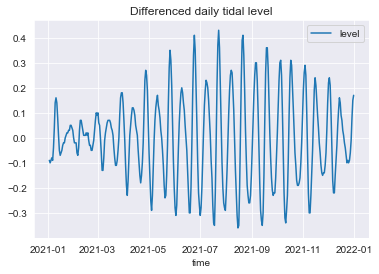

[Text(0.5, 1.0, '2nd order Differenced daily tidal level')]

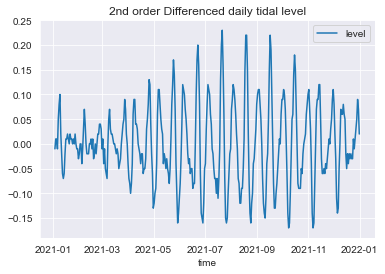

In [44]:
tide_diff = dailytide.diff(periods=1)[1:]
tide_diff_2nd = tide_diff.diff(periods=1)[1:]

sns.lineplot(data=tide_diff, color="r").set(title = "Differenced daily tidal level")
plt.show()
sns.lineplot(data=tide_diff_2nd, color="b").set(title = "2nd order Differenced daily tidal level")

# def plot_acf_pacf(series):
#     fig, axes = plt.subplots(2, 1, figsize=(16, 10), dpi=100)
#     plot_acf(series.tolist(), lags=50, ax=axes[0])
#     plot_pacf(series.tolist(), lags=50, ax=axes[1])
#     plt.show()

# plot_acf_pacf(tide_diff.squeeze())
# ad_test(tide_diff)

## Combined Plot

[Text(0.5, 1.0, 'Tidal Water Level and Temperature Recorded')]

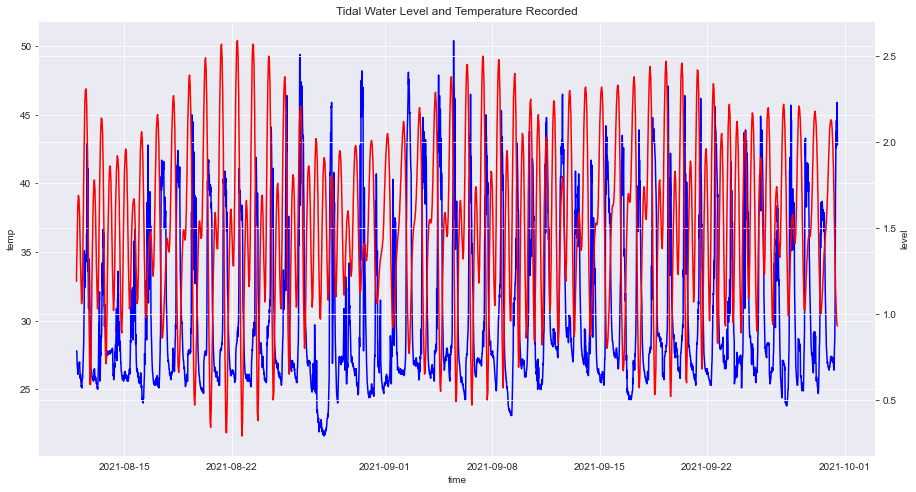

In [11]:
plt.figure(figsize=(15,8))
sns.lineplot(data=combinedf.temp, color="b")
ax2 = plt.twinx()
sns.lineplot(data=combinedf.level, color="r", ax=ax2).set(title='Tidal Water Level and Temperature Recorded')

[Text(0.5, 1.0, 'Tidal Water Level and Temperature Recorded')]

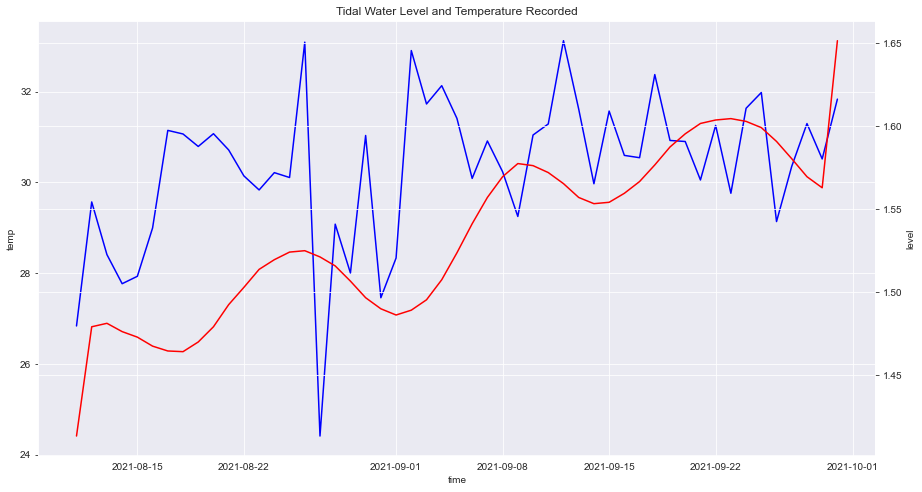

In [12]:
plt.figure(figsize=(15,8))
sns.lineplot(data=combinedmean.temp, color="b")
ax2 = plt.twinx()
sns.lineplot(data=combinedmean.level, color="r", ax=ax2).set(title='Tidal Water Level and Temperature Recorded')

# PACF, ACF

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [14]:
ad_test(tide.level)

1. ADF :  -0.38304284988919024
2. P-Value :  0.9128917478691023
3. Num Of Lags :  37
4. Num Of Observations Used For ADF Regression: 8722
5. Critical Values :
	 1% :  -3.431099968539641
	 5% :  -2.86187143613454
	 10% :  -2.5669464184887825


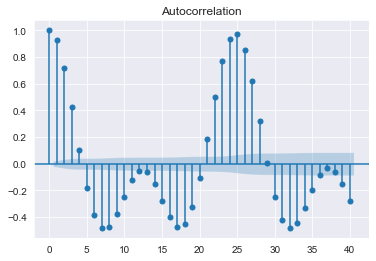

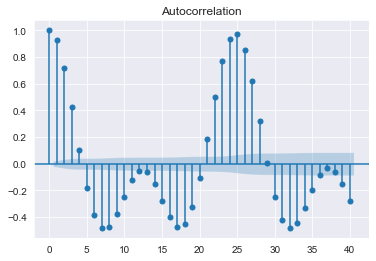

In [15]:
plot_acf(tide.level)

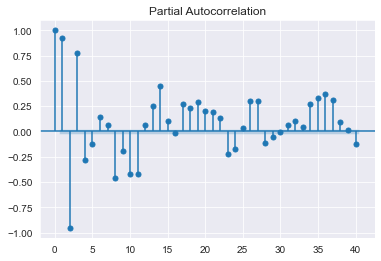

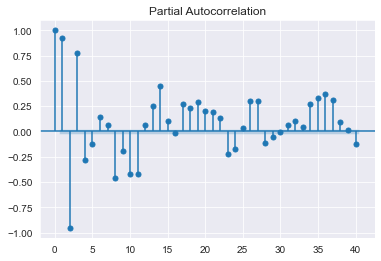

In [16]:
plot_pacf(tide)

In [17]:
ad_test(temp)

1. ADF :  -14.131571202517847
2. P-Value :  2.3287219079847498e-26
3. Num Of Lags :  26
4. Num Of Observations Used For ADF Regression: 4738
5. Critical Values :
	 1% :  -3.431730930009184
	 5% :  -2.862150214311868
	 10% :  -2.56709481909375


In [18]:
ad_test(slicedtide)

1. ADF :  -4.6275379800528045
2. P-Value :  0.00011488620699063695
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression: 1169
5. Critical Values :
	 1% :  -3.435956259544601
	 5% :  -2.8640155784421606
	 10% :  -2.568088052103053


In [19]:
from pmdarima import auto_arima
stepwise_model = auto_arima(
    tide.level, trace=True, suppress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-34953.977, Time=10.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3415.496, Time=1.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16548.537, Time=0.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14336.716, Time=2.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3417.494, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-29673.954, Time=8.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-33891.494, Time=9.87 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-34686.831, Time=15.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-35166.373, Time=14.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-33304.423, Time=13.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-36262.895, Time=17.39 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-35892.264, Time=22.82 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-36707.456, Time=19.29 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-36825.915, Time=16.78 sec

KeyboardInterrupt: 

In [19]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(tide.level, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  level   No. Observations:                 8760
Model:                 ARIMA(1, 1, 2)   Log Likelihood               14841.974
Date:                Sat, 23 Apr 2022   AIC                         -29675.948
Time:                        18:15:05   BIC                         -29647.636
Sample:                    01-01-2021   HQIC                        -29666.301
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8169      0.007    123.663      0.000       0.804       0.830
ma.L1          1.0306      0.006    173.618      0.000       1.019       1.042
ma.L2          0.8309      0.006    141.894      0.0

# Seasonal Decomposition

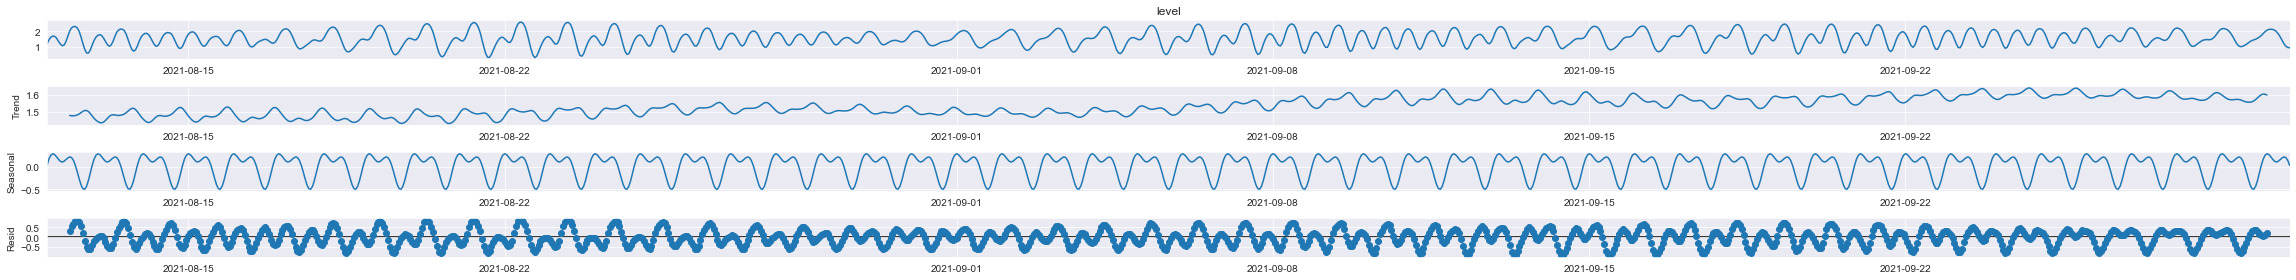

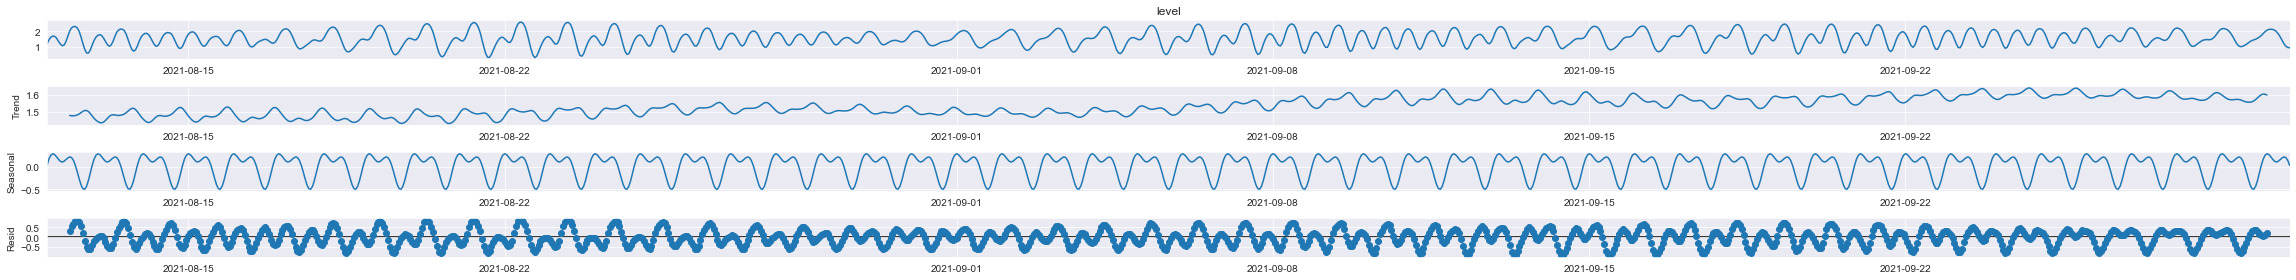

In [20]:
import statsmodels.api as sm
from matplotlib import rcParams

decomposition = sm.tsa.seasonal_decompose(slicedtide["level"], model="additive")
rcParams["figure.figsize"] = 32,4
decomposition.plot()